<a href="https://colab.research.google.com/github/eadewusic/Ekonify-MLOP/blob/main/MLOPS__Eunice_Adewusi_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency.


## Project Details

* **Name:** Ekonify
* **Aim:** To develop a machine learning-based waste classification system using publicly available datasets, demonstrating the applicability of AI in addressing urban waste challenges and optimising recycling processes.
* **Project Goal:** To develop an AI-powered waste classification system that can automatically identify and categorize waste into predefined classes, improving recycling efficiency and environmental sustainability.


**Dataset Used:** https://www.kaggle.com/datasets/mostafaabla/garbage-classification?select=garbage_classification


# Case Study and Implementation




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
100% 238M/239M [00:12<00:00, 22.8MB/s]
100% 239M/239M [00:12<00:00, 19.9MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('garbage-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
#Import Necessary Libraries
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageOps
from glob import glob
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, Dense, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models, Input, regularizers
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import joblib
import shutil
import random
from tqdm import tqdm  # For progress bar
from tensorflow.keras.models import load_model
from google.colab import files

# The Dataset

#### **Problem Statement**  
According to the World Bank's What a Waste 2.0 report, low-income countries often have recycling rates below 5%, compared to high-income countries where rates exceed 40%. Lagos faces similar challenges due to a growing population and limited waste management infrastructure. Manual sorting is time-consuming, costly, and prone to errors, while public unawareness worsens inefficiencies. While studies like TrashNet and Garbage Type Detection demonstrate the potential of machine learning in waste classification, their reliance on generalised datasets limits their adaptability to specific regions like Lagos. Additionally, these solutions lack integration with public engagement platforms, which are crucial for driving scalable, community-wide impact. How can AI bridge the gap in Lagos' waste management system and catalyse a greener, more sustainable future for its 20+ million residents?

#### **Dataset Description**  
The **"Garbage Classification (12 classes)"** dataset contains images of various types of waste categorized into 12 distinct classes. These categories represent common waste types found in recycling and disposal systems. The dataset is designed for training machine learning models, particularly deep learning models like Convolutional Neural Networks (CNNs), to classify waste accurately.  

**Key Features of the Dataset:**  
- **Number of Classes:** 12  
- **Waste Categories:**  
  - Battery  
  - Biological  
  - Brown Glass  
  - Cardboard  
  - Clothes  
  - Green Glass  
  - Metal  
  - Paper  
  - Plastic  
  - Shoes  
  - Trash  
  - White Glass  
- **Image Format:** RGB (3 channels)  
- **Typical Image Size:** Can be resized to **224x224x3** for CNN input  
- **Use Case:** Automated waste classification for recycling and environmental sustainability  

This dataset provides a solid foundation for building an AI-powered waste sorting system, helping reduce pollution and improve waste management processes.

In [ ]:
dataset_path = "/content/garbage_classification"

# Find image files inside all subfolders
image_files = glob(os.path.join(dataset_path, "*", "*.jpg")) + \
              glob(os.path.join(dataset_path, "*", "*.png")) + \
              glob(os.path.join(dataset_path, "*", "*.jpeg"))

if not image_files:
    print("No images found in subfolders.")
else:
    print(f"Found {len(image_files)} images.")

# Use the first image
first_image_path = image_files[0]
print("First image path:", first_image_path)

Found 15515 images.
First image path: /content/garbage_classification/trash/trash688.jpg


Image Size: (183, 276)
Number of Channels: 3
Found 15515 files belonging to 12 classes.
Batch size 16 works!
Found 15515 files belonging to 12 classes.
Batch size 32 works!
Found 15515 files belonging to 12 classes.
Batch size 64 works!


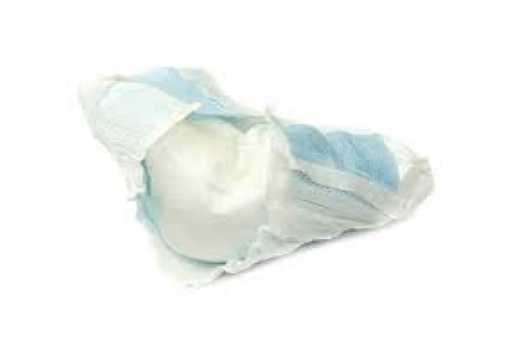

In [ ]:
# Load the first image
image = cv2.imread(first_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Get dimensions
IMAGE_SIZE = image.shape[:2]  # (height, width)
CHANNELS = image.shape[2]  # Number of channels

print("Image Size:", IMAGE_SIZE)
print("Number of Channels:", CHANNELS)

# Test batch sizes
for batch in [16, 32, 64]:
    try:
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            image_size=IMAGE_SIZE,
            batch_size=batch
        )
        print(f"Batch size {batch} works!")
    except:
        print(f"Batch size {batch} is too large!")

# Show the image
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
# Image dimensions
IMAGE_SIZE = (224, 224)  # Standardizing to 224x224
CHANNELS = 3  # RGB images
BATCH_SIZE = 32

In [ ]:
# Dataset directory
dataset_path = "/content/garbage_classification"

# Load training & validation datasets
train_dataset = image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),  # Forces resizing to (224, 224)
    batch_size=32  # Ensure batch size is correct
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),  # Forces resizing
    batch_size=32
)

# Print class names (categories)
class_names = train_dataset.class_names
print("Classes:", class_names)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.
Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [ ]:
#The length of the dataset
len(dataset)

243

In [ ]:
#A batch of 32 and each image now has size of 224 * 224 pixels
for image_batch, label_batch in train_dataset.take(1):
  print("Image batch shape:", image_batch.shape)
  print("Label batch shape:", label_batch.shape)
  print(label_batch.numpy())

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
[ 5  0  9  4  7  8  9  1  3  4  8  1  7  8  0 10 10  7  4  0  4  4  5  7
  5  4  9  4  4  1  8  9]


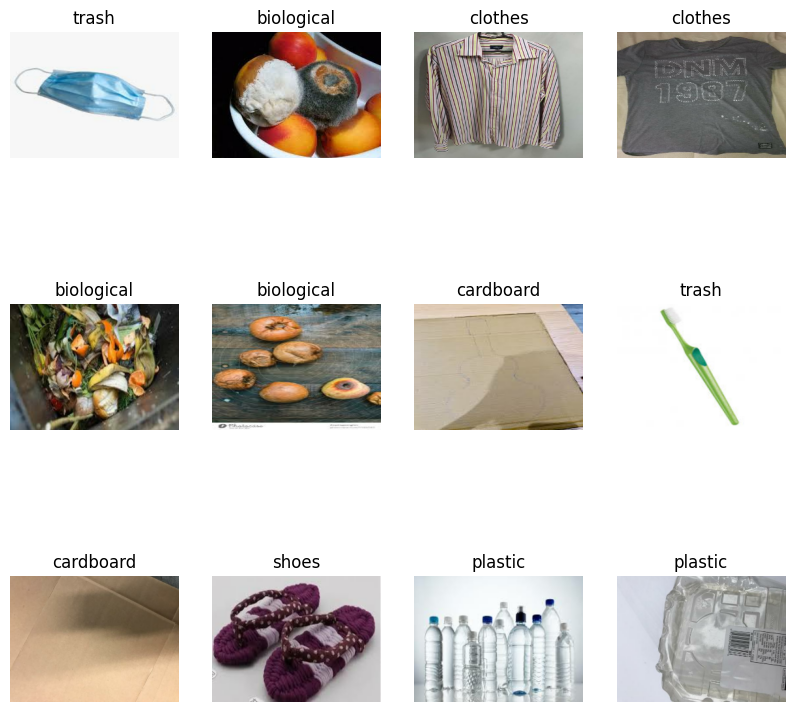

In [ ]:
#Viewing first 12 images in the batch
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
# Normalize the pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# Split training dataset further to create a test set
test_size = int(0.1 * len(train_dataset))
test_dataset = train_dataset.take(test_size)
train_dataset = train_dataset.skip(test_size)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 350
Validation samples: 97
Test samples: 38


In [ ]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

# Apply to training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#SECTION 1: Model Architecture:

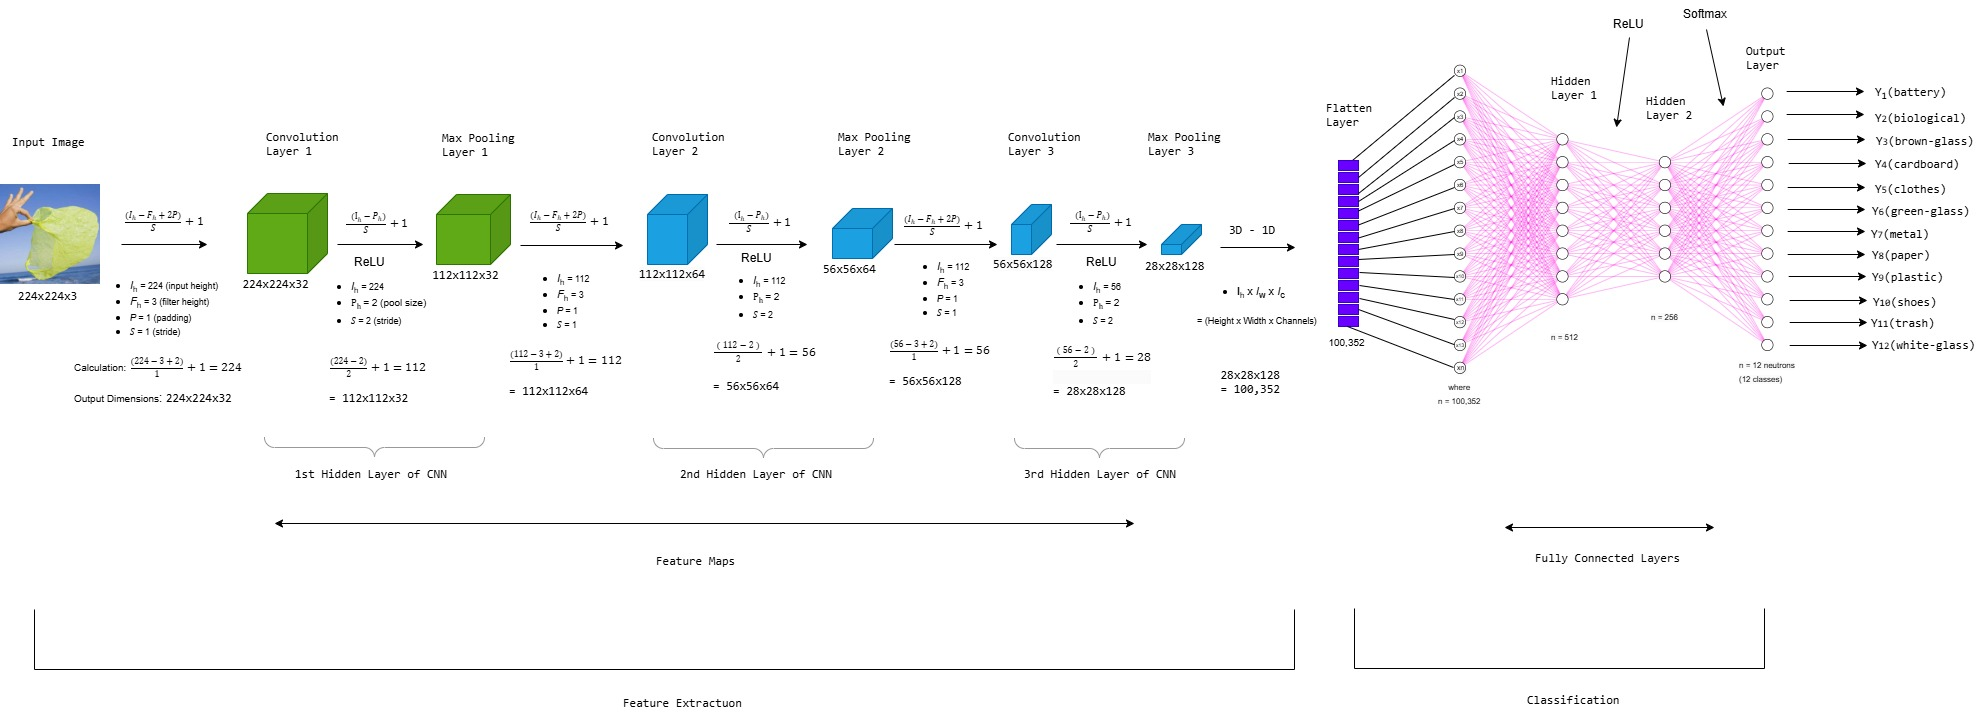


#Task: Define a function that creates models without and With specified Optimization techniques


## **Model 1: Baseline CNN (No Optimization)**
Starting with a simple CNN as a baseline.

In [ ]:
def create_baseline_model():
    model = models.Sequential([
        Input(shape=(224, 224, 3)),  # Explicit Input Layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')  # Output layer
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Instantiate the model
baseline_model = create_baseline_model()
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,508 (42.61 MB)

 Trainable params: 11,170,508 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_baseline = baseline_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Keep epochs low for the baseline
)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 871s 2s/step - accuracy: 0.4281 - loss: 1.8564 - val_accuracy: 0.6007 - val_loss: 1.1647
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 911s 3s/step - accuracy: 0.6111 - loss: 1.1527 - val_accuracy: 0.6387 - val_loss: 1.0617
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 844s 2s/step - accuracy: 0.6477 - loss: 1.0451 - val_accuracy: 0.6603 - val_loss: 1.0106
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - accuracy: 0.6777 - loss: 0.9619 - val_accuracy: 0.6822 - val_loss: 0.9828
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - accuracy: 0.7013 - loss: 0.8848 - val_accuracy: 0.7116 - val_loss: 0.9131
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 880s 3s/step - accuracy: 0.7309 - loss: 0.8204 - val_accuracy: 0.7238 - val_loss: 0.8887
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 871s 2s/step - accuracy: 0.7414 - loss: 0.7853 - val_accuracy: 0.7009 - val_loss: 0.9802
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 857s 2s/step - accuracy: 0.7404 - loss: 0.7761 - val_accu

In [ ]:
# check model's performance on unseen test data after training
test_perf_baseline = baseline_model.evaluate(test_dataset)
print(f"Baseline Model - Test Loss: {test_perf_baseline[0]}, Test Accuracy: {test_perf_baseline[1]}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 676ms/step - accuracy: 0.7228 - loss: 0.8791
Baseline Model - Test Loss: 0.8362571001052856, Test Accuracy: 0.7310855388641357


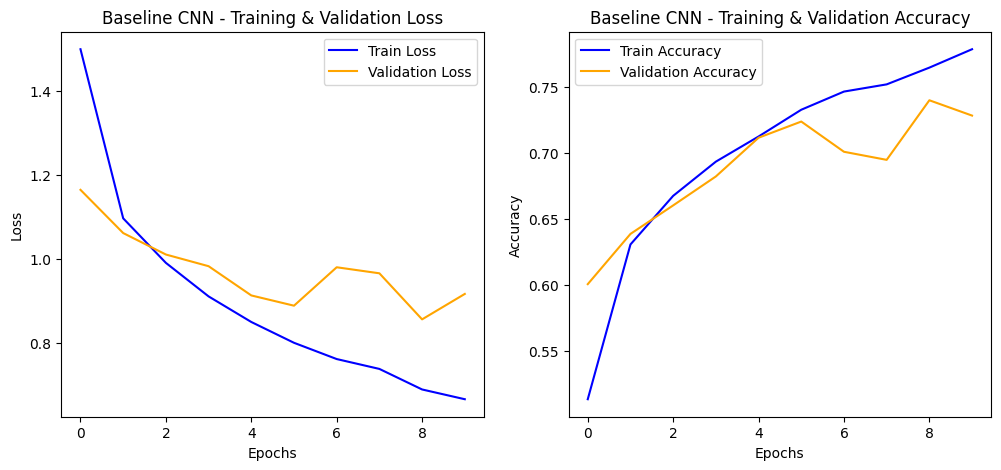

In [ ]:
# Improved Training & Validation Plot
def plot_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))

    # Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.legend()

    # Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training & Validation Accuracy')
    plt.legend()

    plt.show()

# Plot the graphs
plot_history(history_baseline, "Baseline CNN")

First image to predict:
Actual label on dataset: clothes
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
Predicted label by model: clothes


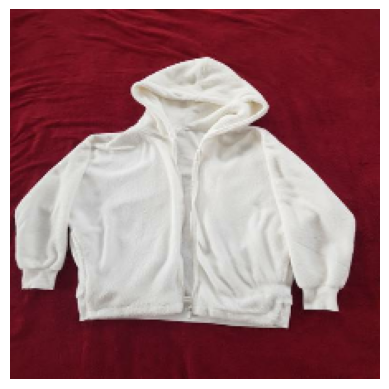

In [ ]:
# Making a single prediction
for images_batch, labels_batch in test_dataset.take(1):
    img_1 = images_batch[0].numpy()  # Remove 'uint8' conversion so image can retain [0, 1] instead of [0, 255]
    img1_label = labels_batch[0].numpy()

    print('First image to predict:')
    plt.imshow(img_1)
    print('Actual label on dataset:', class_names[img1_label])

    batch_prediction = baseline_model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]

    print('Predicted label by model:', predicted_label)
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


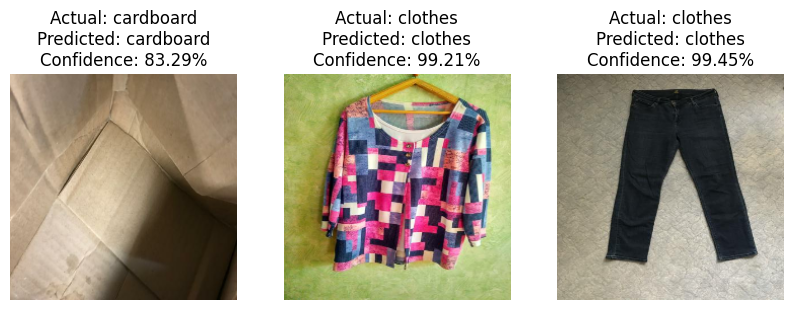

In [ ]:
# Making more predictions
def predict(model, img):
    # Convert image to array and expand dims for prediction
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Model expects batch format

    predictions = baseline_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence_level = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence_level

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(3):  # Predict for 3 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())

        predicted_class, confidence_level = predict(baseline_model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]  # Ensure correct label index

        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence_level}%')
        plt.axis("off")

plt.show()

In [ ]:
#Since Baseline CNN is a Keras model, the best way to save it is using the .keras format

# Create the directory if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

# Now save the model
baseline_model.save("saved_models/baseline_cnn.keras")

In [ ]:
print("Saved models:", os.listdir("saved_models"))

Saved models: ['baseline_cnn.keras', 'optimized_cnn.keras']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

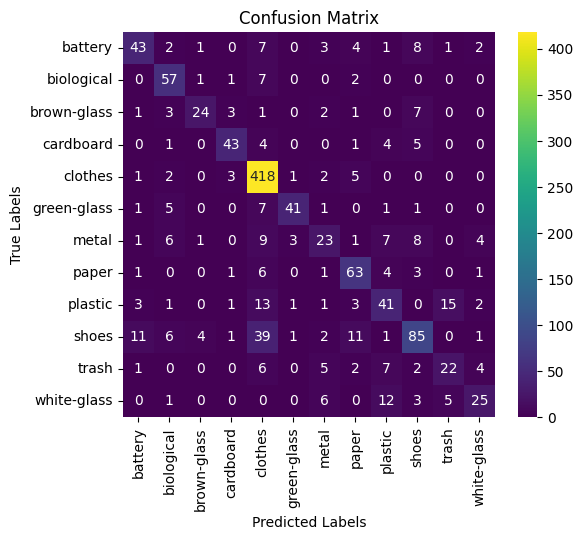

In [ ]:
#Error Analysis visualization

# Step 1: Get true labels and predictions from the test set
y_true = []
y_pred = []

# Collect true labels and predictions
for images, labels in test_dataset:
    preds = baseline_model.predict(images)  # Predict class probabilities
    y_true.extend(labels.numpy().astype(int))  # Convert true labels to int
    y_pred.extend(np.argmax(preds, axis=1))  # Get predicted class index

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Step 3: Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Step 4: Model Performance Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print performance metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")

# Step 5: Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## **The Overall Best Performing Model: Baseline Model (Model 1)**

* Accuracy: 72.78% (Highest)
* Precision: 68.17% (Highest)
* F1 Score: 64.84% (Highest)
* Best Balance of Performance Across All Metrics

## **Why?**

* Model 1 had no regularization but still outperformed all fine-tuned instances and Model 2
*  Its simpler architecture was less prone to overfitting compared to models with L2 regularization + dropout
* Adam optimizer with default learning rate provided stable convergence

## **Beginning of MLOP Task**

### 1. Preprocessing

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/garbage_images.zip"

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Datasets/garbage_images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
# Image Preprocessing
img_height, img_width = 224, 224
batch_size = 32
channels = 3 #RGB images

In [ ]:
dataset_path = "/content/garbage_classification"

# Find image files inside all subfolders
image_files = glob(os.path.join(dataset_path, "*", "*.jpg")) + \
              glob(os.path.join(dataset_path, "*", "*.png")) + \
              glob(os.path.join(dataset_path, "*", "*.jpeg"))

if not image_files:
    print("No images found in subfolders.")
else:
    print(f"Found {len(image_files)} images.")

# Use the first image
first_image_path = image_files[0]
print("First image path:", first_image_path)

Found 15515 images.
First image path: /content/garbage_classification/plastic/plastic433.jpg


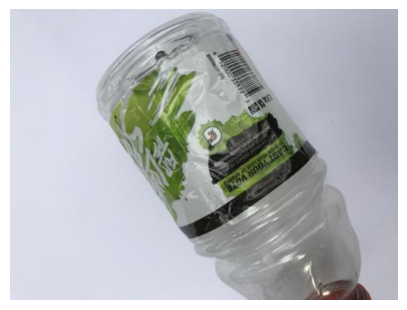

In [ ]:
# Load the first image
image = cv2.imread(first_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Show the image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Define paths
original_data_dir = "/content/garbage_classification"
copied_data_dir = "/content/copied_dataset"  # New copied dataset path

# Function to copy dataset
def copy_dataset(src, dst):
    if os.path.exists(dst):
        print("Copy already exists. Skipping copying step.")
        return
    shutil.copytree(src, dst, dirs_exist_ok=True)
    print(f" Copied dataset to {dst}")

# Copy dataset
copy_dataset(original_data_dir, copied_data_dir)

 Copied dataset to /content/copied_dataset


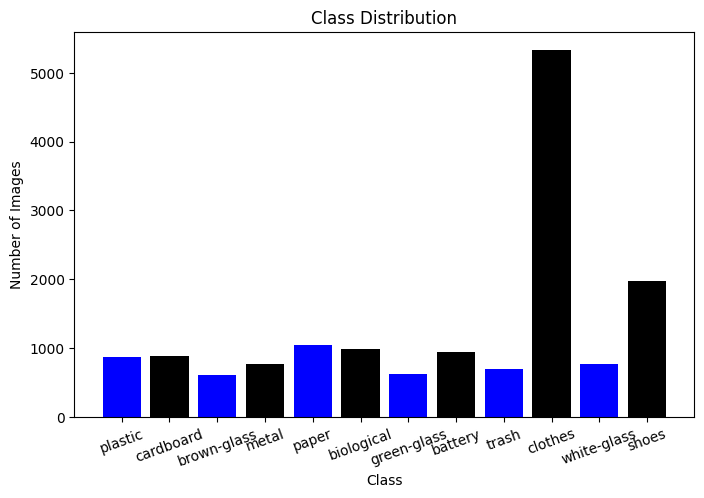

Class counts: {'plastic': 865, 'cardboard': 891, 'brown-glass': 607, 'metal': 769, 'paper': 1050, 'biological': 985, 'green-glass': 629, 'battery': 945, 'trash': 697, 'clothes': 5325, 'white-glass': 775, 'shoes': 1977}


In [ ]:
#Check class balance

# Ensure we only count directories (not files)
class_counts = {
    cls: len(os.listdir(os.path.join(copied_data_dir, cls)))
    for cls in os.listdir(copied_data_dir) if os.path.isdir(os.path.join(copied_data_dir, cls))
}

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'black'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=20)
plt.show()

print("Class counts:", class_counts)

In [ ]:
# Oversample function (increase smaller classes by duplicating)
def oversample_data(copied_data_dir, new_data_dir):
    # Check if copied_data_dir exists
    if not os.path.exists(copied_data_dir):
        print(f"Error: The source directory '{copied_data_dir}' does not exist.")
        return

    # Get the class counts from the source directory
    class_counts = {cls: len(os.listdir(os.path.join(copied_data_dir, cls))) for cls in os.listdir(copied_data_dir)}
    print(f"Class counts in source directory: {class_counts}")

    # Find the class with the most images (target for oversampling)
    max_class = max(class_counts, key=class_counts.get)
    max_count = class_counts[max_class]

    # Create new data directory if it doesn't exist
    if not os.path.exists(new_data_dir):
        os.makedirs(new_data_dir)

    # Loop through each class in the copied data directory
    for cls in os.listdir(copied_data_dir):
        cls_path = os.path.join(copied_data_dir, cls)
        new_class_path = os.path.join(new_data_dir, cls)

        # Create class folder in the new directory if it doesn't exist
        if not os.path.exists(new_class_path):
            os.makedirs(new_class_path)

        # Get all image paths for the current class
        images = os.listdir(cls_path)
        num_images = len(images)

        print(f"Processing class '{cls}': {num_images} images found.")

        # Always copy original images first
        for img in images:
            img_path = os.path.join(cls_path, img)
            print(f"Copying original image: {img}")
            shutil.copy(img_path, os.path.join(new_class_path, img))

        # If the current class has fewer images than the max, duplicate images
        if num_images < max_count:
            additional_needed = max_count - num_images
            print(f"Class '{cls}' needs {additional_needed} more images to match {max_count}. Duplicating...")
            for i in range(additional_needed):
                img_to_copy = random.choice(images)
                original_path = os.path.join(cls_path, img_to_copy)

                # Create a new filename to avoid overwriting existing files
                base_name, ext = os.path.splitext(img_to_copy)
                new_name = f"{base_name}_dup{i}{ext}"
                print(f"Copying duplicate image as {new_name}")
                shutil.copy(original_path, os.path.join(new_class_path, new_name))

        print(f"Oversampled {cls} to {max_count} images in new dataset.")

# Apply oversampling
copied_data_dir = "/content/copied_dataset"
new_data_dir = "/content/oversampled_dataset"
oversample_data(copied_data_dir, new_data_dir)

Streaming output truncated to the last 5000 lines.
Copying original image: shoes5.jpg
Copying original image: shoes1393.jpg
Copying original image: shoes485.jpg
Copying original image: shoes856.jpg
Copying original image: shoes1220.jpg
Copying original image: shoes1164.jpg
Copying original image: shoes116.jpg
Copying original image: shoes1364.jpg
Copying original image: shoes836.jpg
Copying original image: shoes1442.jpg
Copying original image: shoes86.jpg
Copying original image: shoes1865.jpg
Copying original image: shoes1425.jpg
Copying original image: shoes1346.jpg
Copying original image: shoes714.jpg
Copying original image: shoes990.jpg
Copying original image: shoes1511.jpg
Copying original image: shoes926.jpg
Copying original image: shoes1825.jpg
Copying original image: shoes1171.jpg
Copying original image: shoes886.jpg
Copying original image: shoes1149.jpg
Copying original image: shoes170.jpg
Copying original image: shoes798.jpg
Copying original image: shoes1933.jpg
Copying origin

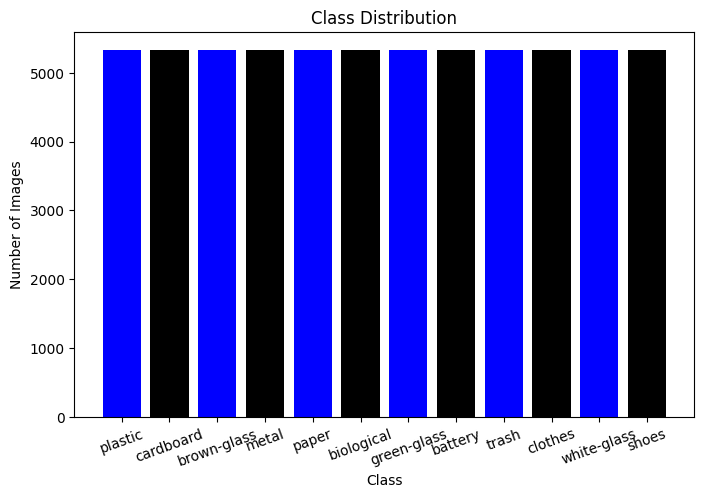

Class counts: {'plastic': 5325, 'cardboard': 5325, 'brown-glass': 5325, 'metal': 5325, 'paper': 5325, 'biological': 5325, 'green-glass': 5325, 'battery': 5325, 'trash': 5325, 'clothes': 5325, 'white-glass': 5325, 'shoes': 5325}


In [ ]:
#Check class balance after oversampling

oversampled_dataset_dir = "/content/oversampled_dataset"

# Ensure we only count directories (not files)
class_counts = {
    cls: len(os.listdir(os.path.join(oversampled_dataset_dir, cls)))
    for cls in os.listdir(oversampled_dataset_dir) if os.path.isdir(os.path.join(oversampled_dataset_dir, cls))
}

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'black'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=20)
plt.show()

print("Class counts:", class_counts)

### 2. Data Splitting

In [ ]:
# Function to split dataset into train, validation, and test (without moving files, just duplicating)
def split_dataset(source_dir, train_dir, val_dir, test_dir, split=(0.8, 0.1, 0.1)):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

        if os.path.isdir(class_path):
            # Create class directories in train, val, and test
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            # Get all image filenames
            filenames = os.listdir(class_path)
            random.shuffle(filenames)

            # Calculate the split indices
            total_files = len(filenames)
            train_end = int(total_files * split[0])
            val_end = int(total_files * (split[0] + split[1]))

            # Split the filenames
            train_files = filenames[:train_end]
            val_files = filenames[train_end:val_end]
            test_files = filenames[val_end:]

            # Copy files to corresponding directories (instead of moving)
            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_dir, class_name, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

            # Print out confirmation for each class
            print(f"Class '{class_name}' has been split and saved into train, val, and test directories.")

# Paths
source_dir = "/content/oversampled_dataset"
train_dir = "/content/train_data"
val_dir = "/content/val_data"
test_dir = "/content/test_data"

# Split data
split_dataset(source_dir, train_dir, val_dir, test_dir)

Class 'plastic' has been split and saved into train, val, and test directories.
Class 'cardboard' has been split and saved into train, val, and test directories.
Class 'brown-glass' has been split and saved into train, val, and test directories.
Class 'metal' has been split and saved into train, val, and test directories.
Class 'paper' has been split and saved into train, val, and test directories.
Class 'biological' has been split and saved into train, val, and test directories.
Class 'green-glass' has been split and saved into train, val, and test directories.
Class 'battery' has been split and saved into train, val, and test directories.
Class 'trash' has been split and saved into train, val, and test directories.
Class 'clothes' has been split and saved into train, val, and test directories.
Class 'white-glass' has been split and saved into train, val, and test directories.
Class 'shoes' has been split and saved into train, val, and test directories.


In [ ]:
# Define ImageDataGenerator for the training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to [0, 1]
    rotation_range=40,  # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Apply random shear transformations
    zoom_range=0.2,  # Apply random zoom transformations
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest valid pixel
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for validation
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for testing

# Create generators for train, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize to the input shape your model expects
    batch_size=32,
    class_mode='categorical'  # For multi-class classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 51120 images belonging to 12 classes.
Found 6384 images belonging to 12 classes.
Found 6396 images belonging to 12 classes.


In [ ]:
# extract class names from the train_generator
class_names = list(train_generator.class_indices.keys())  # Get class names from the generator
print(f"Number of classes: {len(class_names)}")  # Should print 12

Number of classes: 12


### 3. Loading my best performing model from "Intro to ML"

In [ ]:
baseline_model = load_model('/content/saved_models/baseline_cnn.keras')
print("Baseline Model loaded successfully!")

Baseline Model loaded successfully!


In [ ]:
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,511,526 (127.84 MB)

 Trainable params: 11,170,508 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,341,018 (85.22 MB)

### 4. Retraining the Baseline Model

In [ ]:
# Use input from first real layer (since Sequential hasn't been called)
input_layer = baseline_model.layers[0].input
x = input_layer

conv2d_count = 0

# Loop through *all* layers, including the first
for layer in baseline_model.layers:
    config = layer.get_config()

    # Only get weights if NOT Flatten or Dense
    if not isinstance(layer, (layers.Flatten, layers.Dense)):
        weights = layer.get_weights()  # Preserve the original layer's weights

    if isinstance(layer, layers.Conv2D):
        conv2d_count += 1
        config['kernel_regularizer'] = regularizers.l2(0.00004)
        new_layer = layers.Conv2D.from_config(config)  # Create the layer
        new_layer.build(input_shape=x.shape)  # Build the layer if needed

        # Set weights only if they were obtained
        if not isinstance(layer, (layers.Flatten, layers.Dense)):
            new_layer.set_weights(weights)  # Copy weights from original layer

        x = new_layer(x)  # Apply the layer

    elif isinstance(layer, layers.MaxPooling2D):
        x = layers.MaxPooling2D.from_config(config)(x)
        x = layers.Dropout(0.3)(x)

    elif isinstance(layer, layers.Flatten):
        x = layers.GlobalAveragePooling2D()(x)

    elif isinstance(layer, layers.Dense):
        config['kernel_regularizer'] = regularizers.l2(0.000004)

        # Create the Dense layer without applying it immediately
        new_layer = layers.Dense.from_config(config)

        # Build the layer if needed
        new_layer.build(input_shape=x.shape)

        # NO weight setting here — Dense layers will be re-initialized

        # Now apply the layer
        x = new_layer(x)

        # Dropout only after first Dense layer
        if layer.name != 'dense_1':  # Assuming 'dense_1' is the first Dense layer
            x = layers.Dropout(0.4)(x)

    else:
        new_layer = layer.__class__.from_config(config)(x)

        # Set weights only if they were obtained
        if not isinstance(layer, (layers.Flatten, layers.Dense)):
            new_layer.set_weights(weights)  # Copy weights from original layer

        x = new_layer

# Check Conv2D layer count
if conv2d_count < 3:
    print(f"Warning: Only {conv2d_count} Conv2D layers detected — you may need to verify layer[0].")
else:
    print(f"Model includes all {conv2d_count} Conv2D layers.")

# Build new model
improved_baseline_model = models.Model(inputs=input_layer, outputs=x)

# Compile with your desired learning rate
improved_baseline_model.compile(
    optimizer=AdamW(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

improved_baseline_model.summary()

Model includes all 3 Conv2D layers.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,308 (434.80 KB)

 Trainable params: 111,308 (434.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping to stop training when validation loss is not improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Save the model with the best validation accuracy
checkpoint = ModelCheckpoint('retrained_baseline_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Retrain the model with the improved architecture, early stopping, and model checkpoint
history = improved_baseline_model.fit(
    train_generator,  # Train data generator (the better-preprocessed data)
    validation_data=validation_generator,  # Validation data generator
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.4031 - loss: 1.7986
Epoch 1: val_accuracy improved from -inf to 0.58114, saving model to retrained_baseline_model.keras
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 570s 356ms/step - accuracy: 0.4031 - loss: 1.7985 - val_accuracy: 0.5811 - val_loss: 1.2430
Epoch 2/20
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5578 - loss: 1.3290
Epoch 2: val_accuracy improved from 0.58114 to 0.60197, saving model to retrained_baseline_model.keras
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 559s 350ms/step - accuracy: 0.5578 - loss: 1.3290 - val_accuracy: 0.6020 - val_loss: 1.1855
Epoch 3/20
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.5834 - loss: 1.2415
Epoch 3: val_accuracy improved from 0.60197 to 0.64145, saving model to retrained_baseline_model.keras
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 556s 348ms/step - accuracy: 0.5834 - loss: 1.2415 - val_accuracy: 0.6414 - val_loss: 1.0911
Epoch 4/20
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step

The retrained model shows a clear improvement over the original baseline in several key areas:

1. **Higher Validation Accuracy**:
   - The baseline model peaked at **73.99%** val_accuracy.
   - The retrained model improved to **75.17%**, showing better generalization.

2. **Lower Validation Loss**:
   - The baseline model's lowest val_loss was **0.8561**.
   - The retrained model achieved a **lower** val_loss of **0.7940**, indicating better learning.

3. **Smoother Convergence**:
   - The retrained model took **20 epochs** instead of **10**, allowing better optimization.
   - The improvement was more stable with fewer fluctuations compared to the baseline.

In [ ]:
# check model's performance on unseen test data after retraining
test_perf_retrained_baseline = improved_baseline_model.evaluate(test_generator)
print(f"Baseline Model - Test Loss: {test_perf_retrained_baseline[0]}, Test Accuracy: {test_perf_retrained_baseline[1]}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.7383 - loss: 0.7900
Baseline Model - Test Loss: 0.7882607579231262, Test Accuracy: 0.73968106508255


- The retrained model performs slightly better (+0.86%) than the original baseline.
- The new model generalizes better, reducing test loss from 0.8363 to 0.7883.
- The retrained model seems more efficient (200 steps vs. 38 steps for evaluation).

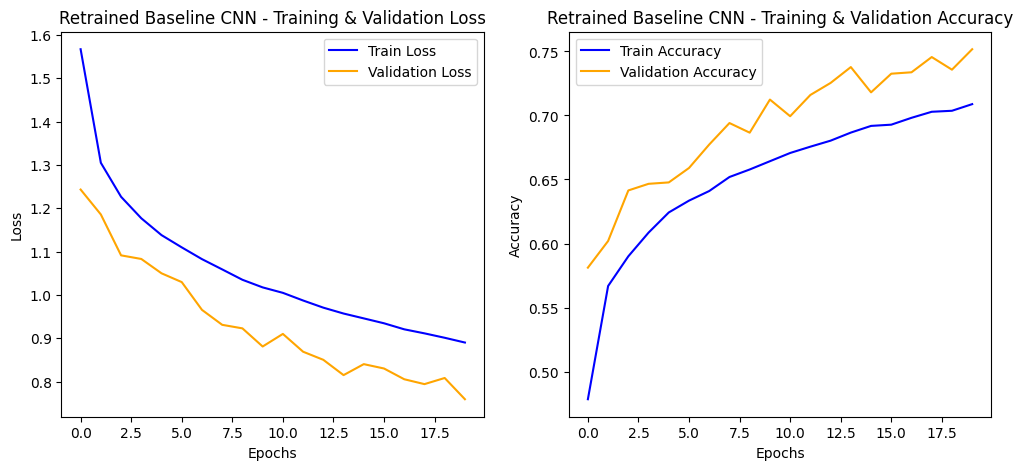

In [ ]:
# Improved Training & Validation Plot
def plot_history(history, model_name="Retrained Model"):
    plt.figure(figsize=(12, 5))

    # Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.legend()

    # Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training & Validation Accuracy')
    plt.legend()

    plt.show()

# Plot the graphs
plot_history(history, "Retrained Baseline CNN")

First image to predict:
Actual label on dataset: brown-glass
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted label by model: brown-glass


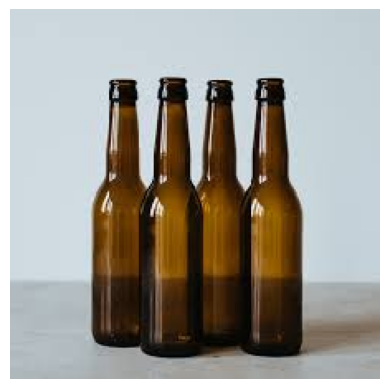

In [ ]:
# Making a single prediction
# Get a batch of images and labels from the test_generator
images_batch, labels_batch = next(test_generator)

img_1 = images_batch[0]
img1_label = np.argmax(labels_batch[0]) # Get the index of the predicted class

print('First image to predict:')
plt.imshow(img_1)
print('Actual label on dataset:', class_names[img1_label])

batch_prediction = improved_baseline_model.predict(images_batch)
predicted_label = class_names[np.argmax(batch_prediction[0])]

print('Predicted label by model:', predicted_label)
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


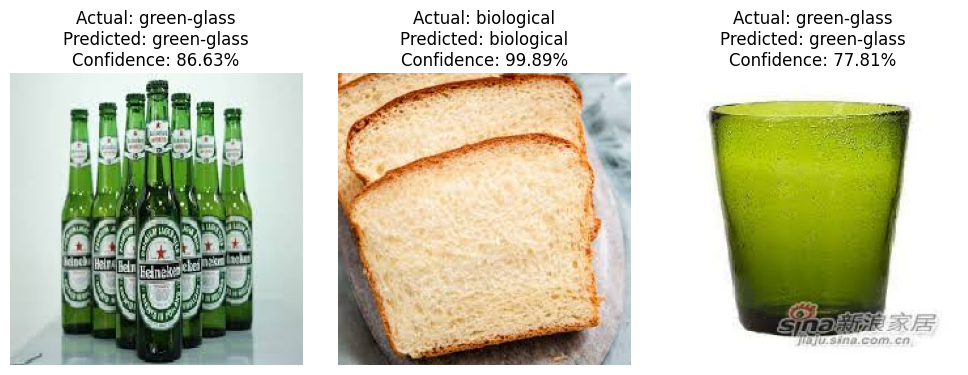

In [ ]:
# Making more predictions
def predict(model, img):
    # Convert image to array and expand dims for prediction
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Model expects batch format

    predictions = improved_baseline_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence_level = f"{100 * np.max(predictions[0]):.2f}"
    return predicted_class, confidence_level

# Get a single batch of data from the test_generator
images_batch, labels_batch = next(test_generator)

plt.figure(figsize=(10, 10))
for i in range(3):  # Predict for 3 images from the batch
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_batch[i])

    predicted_class, confidence_level = predict(improved_baseline_model, images_batch[i])
    actual_class = class_names[np.argmax(labels_batch[i])]  # Ensure correct label index

    plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence_level}%')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [54]:
# Generate predictions for the test set
test_generator.reset()  # Ensure the generator starts from the beginning
predictions = improved_baseline_model.predict(test_generator, steps=len(test_generator), verbose=1)

# Get the predicted class indices
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from the generator
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step
Confusion Matrix (as text):
[[42 49 35 57 51 41 50 66 23 35 29 55]
 [40 49 40 42 65 42 38 68 23 41 36 49]
 [46 50 36 42 52 35 39 64 37 45 34 53]
 [34 38 49 41 59 47 49 64 22 38 35 57]
 [40 54 31 37 39 44 42 78 33 41 31 63]
 [26 58 41 47 40 50 54 60 32 43 35 47]
 [44 46 48 42 49 59 44 60 22 32 35 52]
 [37 44 44 52 41 57 43 66 42 29 31 47]
 [46 50 47 49 41 37 30 71 22 41 39 60]
 [38 55 50 40 51 43 41 64 30 47 35 39]
 [35 42 39 49 61 55 37 64 24 38 33 56]
 [32 51 44 50 57 56 27 57 24 33 39 63]]


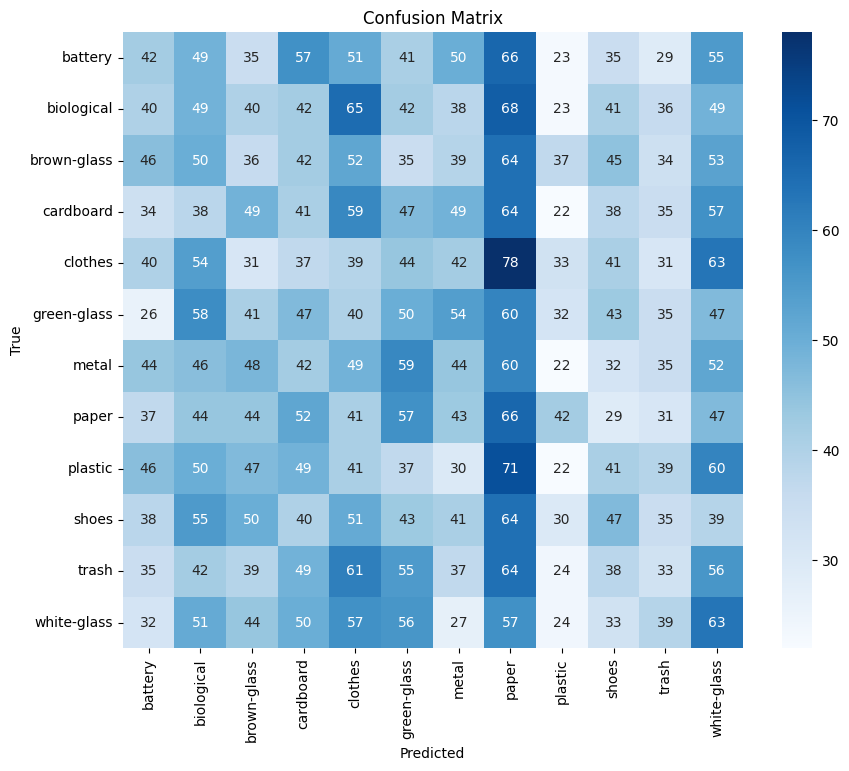

In [60]:
# Generate predictions from the model
y_pred = improved_baseline_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print confusion matrix as text
print("Confusion Matrix (as text):")
print(cm)

# Visualize Confusion Matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     battery       0.09      0.08      0.08       533
  biological       0.09      0.10      0.10       533
 brown-glass       0.10      0.10      0.10       533
   cardboard       0.08      0.09      0.09       533
     clothes       0.07      0.08      0.07       533
 green-glass       0.07      0.08      0.07       533
       metal       0.06      0.06      0.06       533
       paper       0.10      0.15      0.12       533
     plastic       0.09      0.05      0.07       533
       shoes       0.09      0.08      0.08       533
       trash       0.08      0.07      0.07       533
 white-glass       0.07      0.09      0.08       533

    accuracy                           0.08      6396
   macro avg       0.08      0.08      0.08      6396
weighted avg       0.08      0.08      0.08      6396



In [77]:
# Calculate Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Performance Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.0876
Precision: 0.0878
Recall: 0.0876
F1 Score: 0.0868


I don't understand why the model with highest validation accuracy - retrained model, is having this accuracy report. Help!

In [58]:
# Define your directory paths
directories = {
    "train_data": "/content/train_data",
    "val_data": "/content/val_data",
    "test_data": "/content/test_data",
    "oversampled_dataset": "/content/oversampled_dataset",
    "copied_dataset": "/content/copied_dataset"
}

# Loop through each directory, zip, download, and print confirmation
for name, path in directories.items():
    zip_path = f"/content/{name}.zip"

    # Zip the directory
    shutil.make_archive(zip_path.replace('.zip', ''), 'zip', path)
    print(f"Successfully zipped {name}")

    # Download the zip file
    files.download(zip_path)
    print(f"{name}.zip has been downloaded")

Successfully zipped train_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train_data.zip has been downloaded
Successfully zipped val_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

val_data.zip has been downloaded
Successfully zipped test_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test_data.zip has been downloaded
Successfully zipped oversampled_dataset


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

oversampled_dataset.zip has been downloaded
Successfully zipped copied_dataset


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

copied_dataset.zip has been downloaded
